In [113]:
using DifferentialEquations
using Gadfly

set_default_plot_size(20cm, 16cm)

In [114]:
θ = Dict(:α => 2., :β => 1.2, :δ => 1., :γ => 3.)

Dict{Symbol,Float64} with 4 entries:
  :α => 2.0
  :γ => 3.0
  :δ => 1.0
  :β => 1.2

In [115]:
function lotka_volterra!(du,u,θ,t)
    # du = αu - βuv
    du[1] = θ[:α]u[1] - θ[:β]u[1]u[2]
    # dv = δβuv - γv
    du[2] = θ[:β]θ[:δ]u[1]u[2] - θ[:γ]u[2]
end

lotka_volterra! (generic function with 1 method)

In [116]:
u₀ = [1., 1.]
tₛₚₐₙ = (0., 10.)

problem = ODEProblem(lotka_volterra!, u₀, tₛₚₐₙ, θ)

DiffEqBase.ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: [1.0, 1.0]

In [117]:
sol = solve(problem);

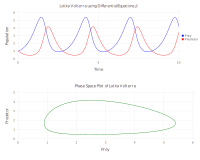

In [118]:
t = linspace(0., 10., 1000)

p1 = plot(
    layer(
        x = t,
        y=[𝑢 for (𝑢, _) ∈ sol(t).u],
        Geom.line,
        color=[colorant"blue" for _ ∈ t]
    ),
    layer(
        x = t,
        y=[𝑣 for (_, 𝑣) ∈ sol(t).u],
        Geom.line,
        color=[colorant"red" for _ ∈ t]
    ),
    Guide.xlabel("Time"),
    Guide.ylabel("Population"),
    Guide.manual_color_key("", ["Prey", "Predator", "Measurements"], ["blue", "red"]),
    Guide.title("Lotka Volterra using DifferentialEquations.jl")
)

t = linspace(0., π, 1000)

p2 = plot(
    x=[𝑢 for (𝑢, _) ∈ sol(t).u],
    y=[𝑣 for (_, 𝑣) ∈ sol(t).u],
    Geom.path, 
    color=[colorant"green" for _ ∈ t],
    Guide.title("Phase Space Plot of Lotka Volterra"),
    Guide.xlabel("Prey"),
    Guide.ylabel("Predator")
)

vstack(p1, p2)

In [119]:
function RK4(f::Function, Δₕ::AbstractFloat, yₙ, tₙ)
    k₁ = Δₕ*f(yₙ, tₙ)
    k₂ = Δₕ*f(yₙ + 0.5k₁, tₙ + 0.5Δₕ)
    k₃ = Δₕ*f(yₙ + 0.5k₂, tₙ + 0.5Δₕ)
    k₄ = Δₕ*f(yₙ + k₃, tₙ + Δₕ)
    
    return yₙ + k₁/6. + k₂/3. + k₃/3. + k₄/6.
end

RK4 (generic function with 1 method)

In [120]:
function lotka_volterra(u,θ,t)
    du = zeros(2)
    # du = αu - βuv
    du[1] = θ[:α]u[1] - θ[:β]u[1]u[2]
    # dv = δβuv - γv
    du[2] = θ[:β]θ[:δ]u[1]u[2] - θ[:γ]u[2]
    
    return du
end

lotka_volterra (generic function with 1 method)

In [121]:
t = linspace(0., 10., 1000)

x = zeros(2,length(t))
x[:,1] = u₀

for i in 2:length(t)
    x[:,i] = RK4((y,t) -> lotka_volterra(y, θ, t), t[i]-t[i-1], x[:,i-1], t[i])
end


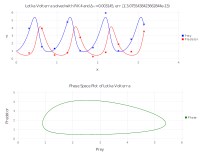

In [127]:
ix = round(Int, length(t) / 10):round(Int, length(t) / 10):length(t)
ts = t[ix]
p1 = plot(
    layer(x = ts, y = x[1, ix] + 0.25 * randn(length(ix)), Geom.point, color=[colorant"blue" for _ ∈ ts]),
    layer(x = ts, y = x[2, ix] + 0.25 * randn(length(ix)), Geom.point, color=[colorant"red" for _ ∈ ts]),
    layer(x = t, y=x[1,:], Geom.line, color=[colorant"blue" for _ ∈ t]),
    layer(x = t, y=x[2,:], Geom.line, color=[colorant"red" for _ ∈ t]),
    Guide.manual_color_key("", ["Prey", "Predator", "Measurements"], ["blue", "red"]),
    Guide.title(@sprintf("Lotka Volterra solved with RK4 and Δₕ=%f, err 𝒪(%s)", t[2]-t[1], string((t[2]-t[1])^5)))
)

t = linspace(0., π, 1000)

p2 = plot(
    x=[𝑢 for (𝑢, _) ∈ sol(t).u],
    y=[𝑣 for (_, 𝑣) ∈ sol(t).u],
    Geom.path, 
    color=[colorant"green" for _ ∈ t],
    Guide.title("Phase Space Plot of Lotka Volterra"),
    Guide.xlabel("Prey"),
    Guide.ylabel("Predator"),
    Guide.manual_color_key("", ["Phase"], ["green"])
)

vstack(p1, p2)


In [ ]:
# function SRK_WO2(f, L, Δₕ, yₙ, tₙ)
#     """ Stochastic Runge Kutta of weak order 2 """
    
# end


## Unscented Transform

In [19]:
function ut(f::Function, x, P; α=1e-3, β=2., κ=0.)
    
    nₓ = length(x)
    Σ  = cholfact(Hermitian(P))[:L]
    
    λ = α^2 * (nₓ + κ) - κ
    
    χ = Array{typeof(x)}(2nₓ + 1)
    for i ∈ 1:2nₓ + 1
        if i - 1 == 0
            χ[i] = x
        elseif i - 1 ≤ nₓ
            χ[i] = x + √(nₓ + λ) * Σ[:,i-1]
        else
            χ[i] = x - √(nₓ + λ) * Σ[:,i-1-nₓ]
        end
    end
    
    return χ, map(f, χ)
end

function ut⁻¹(χ, γ=nothing; α=1e-3, β=2., κ=0.)
    
    γ == nothing ? γ = χ : nothing
    
    nᵪ, nₓ = length(χ), length(χ[1])

    λ = α^2 * (nₓ + κ) - κ
    
    𝐰 = [i == 1 ? λ/(nₓ+λ) : 1/(2*(nₓ+λ)) for i ∈ 1:nᵪ]
    
    x = sum(hcat(𝐰.*χ...), 2)
    y = sum(hcat(𝐰.*γ...), 2)
    
    P = sum([(i == 1 ? 𝐰[i] + (1-α^2 + β) : 𝐰[i])*(x-χ[i])*(y-γ[i])' for i ∈ 1:nᵪ])
                
    return x, P, 𝐰
end

ut⁻¹ (generic function with 2 methods)

In [132]:
f = x -> [cos(x[1]) ; atan2(x[2], x[1])]

using Distributions
x = MvNormal([2;2], [2. 0.5 ; 0.5 4.])

mc = rand(x, 10000)

y_true = hcat([f(x_) for x_ ∈ zip(mc[1,:], mc[2,:])]...)

χ, γ = ut(f, x.μ, x.Σ.mat, α=1e-3, κ=0)

x_ut, Px, _ = ut⁻¹(χ, α=1e-3, κ=0)

y_ut, P_ut, _ = ut⁻¹(γ, α=1e-3, κ=0);

### Plotting an 2-dimensional Gaussian as confidence interval

In [133]:
function ellipse(μ, Σ, p; style::Union{Gadfly.Theme, Void} = nothing, color=nothing, nsegments=51 )
    """ ellipse : error ellipse """
    layers = []
    for 𝑝 ∈ p
        d,v = eig(cquantile(Chisq(2), 1. - 𝑝) * Hermitian(Σ))
        d = [isapprox.(d_, 0., atol=eps()) ? 0. : d_ for d_ ∈ d]
        
        i = sortperm(d, rev=true)
        d, v = diagm(d[i]), v[:,i]

        v = v*sqrt.(d)
        e = hcat([μ + v*[cos(t_), sin(t_)] for t_ ∈ linspace(0, 2π, nsegments)]...)
        
        push!(layers,
            color == nothing ? 
                style == nothing ? 
                    layer(x=e[1,:], y=e[2,:], Geom.path) 
                : 
                    layer(x=e[1,:], y=e[2,:], Geom.path, style )
            :
                style == nothing ?
                    layer(x=e[1,:], y=e[2,:], Geom.path, color=[color for _ ∈ 1:size(e, 2)])
                : 
                    layer(
                        x=e[1,:], y=e[2,:],
                        Geom.path,
                        color=[color for _ ∈ 1:size(e, 2)],
                        style
                    )
        )
    end
    return layers
end

ellipse (generic function with 1 method)

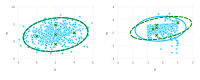

In [134]:
subs = 1:round(Int, length(mc)/1000):size(mc,2)

p1 = plot(
    ellipse(x_ut, Px, .95, color=colorant"green", style=style(line_width=1mm, line_style=:dash))...,
    ellipse(x.μ, x.Σ.mat, .95, style=style(line_width=1mm))...,
    layer(
        x=hcat(χ...)[1,:],
        y=hcat(χ...)[2,:],
        Geom.point,
        color=[colorant"green" for _ ∈ χ],
        shape=[Shape.xcross],
        style(point_size=2mm)
    ),
    layer(
        x=mc[1,subs],
        y=mc[2,subs],
        Geom.point,
    ),
)

p2 = plot(
    ellipse(y_ut, P_ut, .95, color=colorant"green", style=style(line_width=1mm, line_style=:dash))...,#
    ellipse(mean(y_true,2), cov(y_true,2), .95, style=style(line_width=1mm))...,
    layer(
        x=hcat(γ...)[1,:],
        y=hcat(γ...)[2,:],
        Geom.point,
        color=[colorant"green" for _ ∈ χ],
        shape=[Shape.xcross],
        style(point_size=2mm)
    ),
    layer(
        x=y_true[1,subs],
        y=y_true[2,subs],
        Geom.point,
    ),
)

set_default_plot_size(20cm, 8cm)
hstack(p1,p2)

## Unscented Kalman Filter for predicting Lotka Volterra

### Unscented Kalman filter equations

In [191]:
function _proto_predict(m, P, F, Q)
    """ Prototype for Kalman predict """
    return F*m, Hermitian(F*P*F'+Q)
end

function _proto_ut_predict(m, P, f, Q; χ⁻=nothing, θ=Dict(:α=>1e-3,:β=>2.,:κ=>0.))
    """ Prototype for unscented Kalman prediction """
    if χ⁻ == nothing
        _, χ = ut(f, m, P, α=θ[:α], β=θ[:β], κ=θ[:κ])
    else
        χ = map(f, χ⁻)
    end
    
    m⁺, P⁺, _ = ut⁻¹(χ, α=θ[:α], β=θ[:β], κ=θ[:κ])
    return χ, m⁺, Hermitian(P⁺ + Q)
end

function _proto_update(m, P, y, H, R)
    """ Prototype for Kalman update """
    K = P*H'/(H*P*H'+R)
    return m+K*(y-H*m), Hermitian(P-K*(H*P*H'+R)*K')
end

function _proto_ut_update(m, P, y, h, R; χ=nothing, θ=Dict(:α=>1e-3,:β=>2.,:κ=>0.))
    """ Prototype for unscented Kalman update """
    if χ == nothing
        χ, γ = ut(h, m, P, α=θ[:α], β=θ[:β], κ=θ[:κ])
    else
        γ = map(h, χ)
    end
    
    _, Pˣʸ, _ = ut⁻¹(χ, γ, α=θ[:α], β=θ[:β], κ=θ[:κ])
    y⁺, Pʸ, _ = ut⁻¹(γ, α=θ[:α], β=θ[:β], κ=θ[:κ])
    
    K = Pˣʸ / (Pʸ + R)
    return m+K*(y-y⁺), Hermitian(P-K*(Pʸ+R)*K')
end

function unscented_filter(f, Q, h, R; θ=Dict(:α=>1e-3,:β=>2.,:κ=>0.))
    """ Unscented Kalman filter [defaults to linear KF if matrix given]"""
    if typeof(f) <: Function
        predict = (m, P) -> _proto_ut_predict(m, P, f, Q, χ⁻=nothing, θ=θ)
        update = typeof(h) <: Function ?
            (m, P, y, χ) -> _proto_ut_update(m, P, y, h, R, χ=χ, θ=θ) : # h as a function
            (m, P, y) -> _proto_update(m, P, y, h, R)                   # linear h as matrix
    else 
        predict = (m, P) -> _proto_predict(m, P, F, Q)
        update = typeof(h) <: Function ?
            (m, P, y) -> _proto_ut_update(m, P, y, h, R, θ=θ) : # h as a function
            (m, P, y) -> _proto_update(m, P, y, h, R)
    end
    
   return predict, update
end

unscented_filter (generic function with 2 methods)

In [264]:
function _proto_smooth(m⁻, m⁺, P⁻, P⁺, F, Q)
    """ Prototype for RTS smooth """
    G = (P⁻*F'/(F*P⁻*F'+Q))
    return m⁻+ G*(m⁺-F*m⁻), Hermitian(P⁻+G*(P⁺-F*P⁻*F'+Q)*G')
end 

function _proto_unscented_smooth(m⁻, m⁺, P⁻, P⁺, f, Q; θ=Dict(:α=>1e-3,:β=>2.,:κ=>0.))
    """ """
    
    χ⁻, χ = ut(f, m⁻, P⁻, α=θ[:α], β=θ[:β], κ=θ[:κ])
    mᵖ, Pᵖ,_ = ut⁻¹(χ, α=θ[:α], β=θ[:β], κ=θ[:κ])
    _, P, _ = ut⁻¹(χ⁻, χ, α=θ[:α], β=θ[:β], κ=θ[:κ])
    
    G = P / (Pᵖ + Q)
    return m⁻+ G*(m⁺-mᵖ), Hermitian(P⁻+G*(P⁺-(Pᵖ+Q))*G')
end

function unscented_smoother(f, Q; θ=Dict(:α=>1e-3,:β=>2.,:κ=>0.))
    """ """
    return (m⁻, m⁺, P⁻, P⁺) -> _proto_unscented_smooth(m⁻, m⁺, P⁻, P⁺, f, Q, θ=θ)
end

unscented_smoother (generic function with 1 method)

In [192]:
t = linspace(0., 10., 1000)

u₀ = [1., 1.]
θ = Dict(:α => 2., :β => 1.2, :δ => 1., :γ => 3.)

x = zeros(2,length(t))
x[:,1] = u₀

for i in 2:length(t)
    x[:,i] = RK4((y,t) -> lotka_volterra(y, θ, t), t[i]-t[i-1], x[:,i-1], t[i])
end

ix = round(Int, length(t) / 10):round(Int, length(t) / 10):length(t)
ts = collect(t[ix])

10-element Array{Float64,1}:
  0.990991
  1.99199 
  2.99299 
  3.99399 
  4.99499 
  5.996   
  6.997   
  7.998   
  8.999   
 10.0     

In [193]:
𝐇, 𝑹 = [1 0; 0 1], Hermitian(1.*eye(2))

y = hcat([𝐇*x[:, i] + 𝑹*randn(2,1) for i ∈ ix]...);

In [194]:
Δₜ = t[2]-t[1]
nₜ = length(t)

𝑓 = x -> RK4((y,t) -> lotka_volterra(y, θ, t), Δₜ, x, NaN)
𝑸 = Hermitian(eps()*eye(2,2))

2×2 Hermitian{Float64,Array{Float64,2}}:
 2.22045e-16  0.0        
 0.0          2.22045e-16

In [266]:
m₀, P₀ = reshape(u₀, (2,1)), 𝐇\𝑹

𝐟, 𝐏 = Array{typeof(m₀)}(nₜ), Array{typeof(P₀)}(nₜ)

predict, update = unscented_filter(𝑓, 𝑸, 𝐇, 𝑹)

mₜ, Pₜ = m₀, P₀
χ, _ = ut(x->x, m₀, P₀)

𝐟[1] = mₜ
𝐏[1] = Pₜ

for k ∈ 2:nₜ
    _, mₜ, Pₜ = predict(mₜ, Pₜ)

    if t[k] ∈ ts
        j = find(t[k] .== ts)[1]
        mₜ, Pₜ = update(mₜ, Pₜ, y[j])
    end
    
    𝐟[k] = mₜ
    𝐏[k] = Pₜ
end

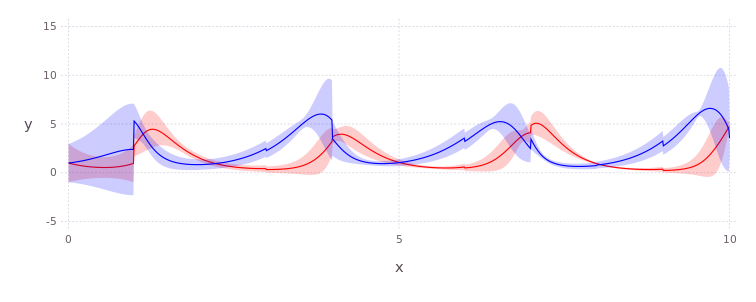

In [267]:
plot(
    layer(
        x = t,
        y = [f[1] for f ∈ 𝐟],
        ymin = [f[1] - 1.96*√abs(σ[1,1]) for (f, σ) ∈ zip(𝐟, 𝐏)],
        ymax = [f[1] + 1.96*√abs(σ[1,1]) for (f, σ) ∈ zip(𝐟, 𝐏)],
        color=[colorant"blue"  for _ ∈ t],
        Geom.line, Geom.ribbon,
        style(lowlight_color=c->RGBA{Float32}(c.r, c.g, c.b, 0.2))
    ),
    layer(
        x = t,
        y = [f[2] for f ∈ 𝐟],
        ymin = [f[2] - 1.96*√abs(σ[2,2]) for (f, σ) ∈ zip(𝐟, 𝐏)],
        ymax = [f[2] + 1.96*√abs(σ[2,2]) for (f, σ) ∈ zip(𝐟, 𝐏)],
        color=[colorant"red" for _ ∈ t],
        Geom.line, Geom.ribbon,
        style(lowlight_color=c->RGBA{Float32}(c.r, c.g, c.b, 0.2))
    )
)

In [268]:
𝐟⁻, 𝐏⁻ = copy(𝐟), copy(𝐏)

# RTS smoothing
smooth = unscented_smoother(𝑓, 𝑸)

for k = nₜ-1:-1:1
    𝐟[k], 𝐏[k] = smooth(𝐟[k],𝐟[k+1],𝐏[k],𝐏[k+1]) 
end

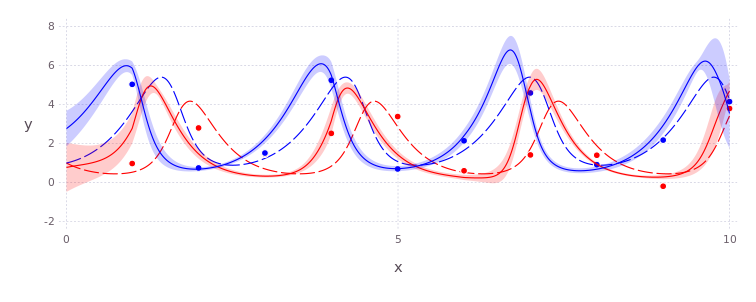

In [274]:
plot(
    layer(
        x = t,
        y = [f[1] for f ∈ 𝐟],
        ymin = [f[1] - 1.96*√abs(σ[1,1]) for (f, σ) ∈ zip(𝐟, 𝐏)],
        ymax = [f[1] + 1.96*√abs(σ[1,1]) for (f, σ) ∈ zip(𝐟, 𝐏)],
        color=[colorant"blue"  for _ ∈ t],
        Geom.line, Geom.ribbon,
        style(lowlight_color=c->RGBA{Float32}(c.r, c.g, c.b, 0.2))
    ),
    layer(
        x = t,
        y = [f[2] for f ∈ 𝐟],
        ymin = [f[2] - 1.96*√abs(σ[2,2]) for (f, σ) ∈ zip(𝐟, 𝐏)],
        ymax = [f[2] + 1.96*√abs(σ[2,2]) for (f, σ) ∈ zip(𝐟, 𝐏)],
        color=[colorant"red" for _ ∈ t],
        Geom.line, Geom.ribbon,
        style(lowlight_color=c->RGBA{Float32}(c.r, c.g, c.b, 0.2))
    ),
    layer(x = ts, y = y[1,:], Geom.point, color=[colorant"blue" for _ ∈ ts]),
    layer(x = ts, y = y[2,:], Geom.point, color=[colorant"red" for _ ∈ ts]),
    layer(x = t, y=x[1,:], Geom.line, color=[colorant"blue" for _ ∈ t], style(line_style=:dash)),
    layer(x = t, y=x[2,:], Geom.line, color=[colorant"red" for _ ∈ t], style(line_style=:dash))
)

In [272]:
ts

10-element Array{Float64,1}:
  0.990991
  1.99199 
  2.99299 
  3.99399 
  4.99499 
  5.996   
  6.997   
  7.998   
  8.999   
 10.0     

In [273]:
y

2×10 Array{Float64,2}:
 5.03323   0.748636  1.51219  5.24213  …  0.916561   2.17572   4.14686
 0.974286  2.79834   1.45704  2.51978     1.39917   -0.190719  3.79472